In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Perceptron

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

/Users/lvshuo/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [3]:
per_clf.coef_

array([[-1.1, -1.3]])

In [4]:
per_clf.intercept_

array([ 3.])

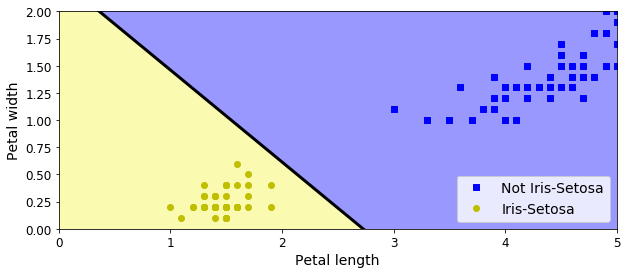

In [5]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap, linewidth=5)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

### Activation functions

In [6]:
def logit(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

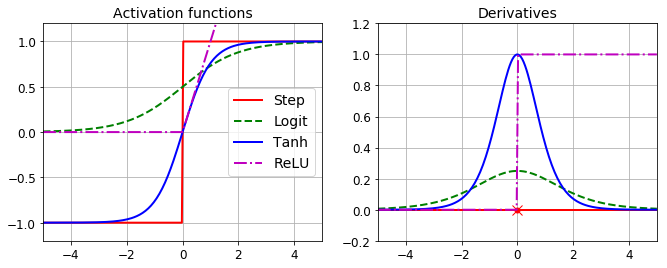

In [7]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, logit(z), "g--", linewidth=2, label="Logit")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)

plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(logit, z), "g--", linewidth=2, label="Logit")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)

plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

In [8]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def sigmoid(z):
    return 1/(1+np.exp(-z))

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

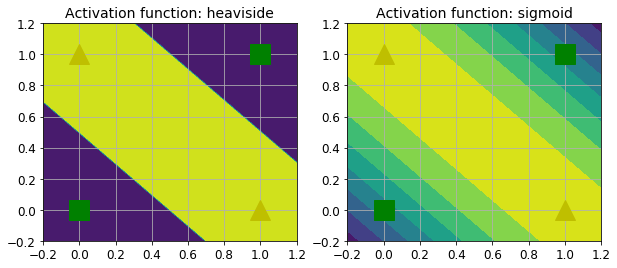

In [9]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

## Train MLP

### Backpropagation 反向传播算法

> 反向传播（英语：Backpropagation，缩写为BP）是“误差反向传播”的简称，是一种与最优化方法（如梯度下降法）结合使用的，用来训练人工神经网络的常见方法

- 第1阶段：**激励传播**

每次迭代中的传播环节包含两步：

    1. （前向传播阶段）将训练输入送入网络以获得激励响应；
    2. （反向传播阶段）将激励响应与训练输入对应的目标输出求差，从而获得隐层和输出层的响应误差。

- 第2阶段：**权重更新**

对于每个突触上的权重，按照以下步骤进行更新：

将输入激励和响应误差相乘，从而获得权重的梯度；
将这个梯度乘上一个比例并取反后加到权重上。
这个比例（百分比）将会影响到训练过程的速度和效果，因此称为“训练因子”。梯度的方向指明了误差扩大的方向，因此在更新权重的时候需要对其取反，从而减小权重引起的误差。

第1和第2阶段可以反复循环迭代，直到网络的对输入的响应达到满意的预定的目标范围为止

### Using Tensorflow's High-Level API

In [14]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [17]:
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

In [18]:
X_train.shape, X_test.shape

((55000, 784), (10000, 784))

In [19]:
import tensorflow as tf

config = tf.contrib.learn.RunConfig(tf_random_seed=42) # not shown in the config

feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                         feature_columns=feature_cols, config=config)
dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # if TensorFlow >= 1.1
dnn_clf.fit(X_train, y_train, batch_size=50, steps=40000)

INFO:tensorflow:Using config: {'_model_dir': None, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': 42, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x105666d10>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/m

INFO:tensorflow:loss = 0.0113093, step = 6901 (0.283 sec)
INFO:tensorflow:global_step/sec: 346.181
INFO:tensorflow:loss = 0.0190613, step = 7001 (0.288 sec)
INFO:tensorflow:global_step/sec: 346.312
INFO:tensorflow:loss = 0.00409009, step = 7101 (0.289 sec)
INFO:tensorflow:global_step/sec: 375.183
INFO:tensorflow:loss = 0.0582136, step = 7201 (0.267 sec)
INFO:tensorflow:global_step/sec: 378.827
INFO:tensorflow:loss = 0.00672715, step = 7301 (0.264 sec)
INFO:tensorflow:global_step/sec: 381.263
INFO:tensorflow:loss = 0.0127499, step = 7401 (0.262 sec)
INFO:tensorflow:global_step/sec: 385.049
INFO:tensorflow:loss = 0.005338, step = 7501 (0.260 sec)
INFO:tensorflow:global_step/sec: 384.913
INFO:tensorflow:loss = 0.0160609, step = 7601 (0.260 sec)
INFO:tensorflow:global_step/sec: 375.061
INFO:tensorflow:loss = 0.00499156, step = 7701 (0.267 sec)
INFO:tensorflow:global_step/sec: 381.311
INFO:tensorflow:loss = 0.00483353, step = 7801 (0.262 sec)
INFO:tensorflow:global_step/sec: 384.843
INFO:te

INFO:tensorflow:loss = 0.00237104, step = 15101 (0.270 sec)
INFO:tensorflow:global_step/sec: 371.762
INFO:tensorflow:loss = 0.00227502, step = 15201 (0.269 sec)
INFO:tensorflow:global_step/sec: 381.697
INFO:tensorflow:loss = 0.00141252, step = 15301 (0.262 sec)
INFO:tensorflow:global_step/sec: 371.363
INFO:tensorflow:loss = 0.00455337, step = 15401 (0.269 sec)
INFO:tensorflow:global_step/sec: 364.811
INFO:tensorflow:loss = 0.00491852, step = 15501 (0.274 sec)
INFO:tensorflow:global_step/sec: 370.069
INFO:tensorflow:loss = 0.00487903, step = 15601 (0.270 sec)
INFO:tensorflow:global_step/sec: 376.692
INFO:tensorflow:loss = 0.0134273, step = 15701 (0.266 sec)
INFO:tensorflow:global_step/sec: 380.762
INFO:tensorflow:loss = 0.00312125, step = 15801 (0.262 sec)
INFO:tensorflow:global_step/sec: 385.703
INFO:tensorflow:loss = 0.000708232, step = 15901 (0.259 sec)
INFO:tensorflow:global_step/sec: 383.319
INFO:tensorflow:loss = 0.00560298, step = 16001 (0.261 sec)
INFO:tensorflow:global_step/sec

INFO:tensorflow:global_step/sec: 372.462
INFO:tensorflow:loss = 0.00193402, step = 23301 (0.268 sec)
INFO:tensorflow:global_step/sec: 382.162
INFO:tensorflow:loss = 0.000599899, step = 23401 (0.262 sec)
INFO:tensorflow:global_step/sec: 370.918
INFO:tensorflow:loss = 0.000690191, step = 23501 (0.269 sec)
INFO:tensorflow:global_step/sec: 368.954
INFO:tensorflow:loss = 0.0006689, step = 23601 (0.271 sec)
INFO:tensorflow:global_step/sec: 378.882
INFO:tensorflow:loss = 0.000450027, step = 23701 (0.264 sec)
INFO:tensorflow:global_step/sec: 366.41
INFO:tensorflow:loss = 0.00181704, step = 23801 (0.273 sec)
INFO:tensorflow:global_step/sec: 382.652
INFO:tensorflow:loss = 0.00110625, step = 23901 (0.261 sec)
INFO:tensorflow:global_step/sec: 378.109
INFO:tensorflow:loss = 0.000971603, step = 24001 (0.265 sec)
INFO:tensorflow:global_step/sec: 358.685
INFO:tensorflow:loss = 0.000599703, step = 24101 (0.279 sec)
INFO:tensorflow:global_step/sec: 370.029
INFO:tensorflow:loss = 0.00103672, step = 24201

INFO:tensorflow:global_step/sec: 377.838
INFO:tensorflow:loss = 0.000609493, step = 31401 (0.265 sec)
INFO:tensorflow:global_step/sec: 382.64
INFO:tensorflow:loss = 0.00025601, step = 31501 (0.261 sec)
INFO:tensorflow:global_step/sec: 385.758
INFO:tensorflow:loss = 8.65842e-05, step = 31601 (0.259 sec)
INFO:tensorflow:global_step/sec: 382.724
INFO:tensorflow:loss = 0.000604256, step = 31701 (0.261 sec)
INFO:tensorflow:global_step/sec: 386.066
INFO:tensorflow:loss = 9.59904e-05, step = 31801 (0.259 sec)
INFO:tensorflow:global_step/sec: 381.926
INFO:tensorflow:loss = 0.00079322, step = 31901 (0.262 sec)
INFO:tensorflow:global_step/sec: 386.674
INFO:tensorflow:loss = 0.000262161, step = 32001 (0.259 sec)
INFO:tensorflow:global_step/sec: 388.074
INFO:tensorflow:loss = 0.000368648, step = 32101 (0.258 sec)
INFO:tensorflow:global_step/sec: 383.422
INFO:tensorflow:loss = 0.00113988, step = 32201 (0.261 sec)
INFO:tensorflow:global_step/sec: 379.809
INFO:tensorflow:loss = 0.00038782, step = 323

INFO:tensorflow:global_step/sec: 380.004
INFO:tensorflow:loss = 0.000248625, step = 39501 (0.263 sec)
INFO:tensorflow:global_step/sec: 377.978
INFO:tensorflow:loss = 0.000750375, step = 39601 (0.265 sec)
INFO:tensorflow:global_step/sec: 369.839
INFO:tensorflow:loss = 0.000224784, step = 39701 (0.270 sec)
INFO:tensorflow:global_step/sec: 381.457
INFO:tensorflow:loss = 0.00105966, step = 39801 (0.262 sec)
INFO:tensorflow:global_step/sec: 394.163
INFO:tensorflow:loss = 0.00136582, step = 39901 (0.254 sec)
INFO:tensorflow:Saving checkpoints for 40000 into /var/folders/m6/wk115c_d5v1cbvy6hjtd5kk00000gn/T/tmpgymUFw/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00045437.


SKCompat()

In [20]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test)
accuracy_score(y_test, y_pred['classes'])

INFO:tensorflow:Restoring parameters from /var/folders/m6/wk115c_d5v1cbvy6hjtd5kk00000gn/T/tmpgymUFw/model.ckpt-40000


0.98240000000000005

In [21]:
from sklearn.metrics import log_loss

y_pred_proba = y_pred['probabilities']
log_loss(y_test, y_pred_proba)

0.071563045266568537

### Using Tensorflow low-level python API

In [22]:
import tensorflow as tf

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [23]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [24]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [25]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

In [26]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [27]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [28]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [29]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 40
batch_size = 50

In [30]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                            y: mnist.validation.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 0.9 Val accuracy: 0.9146
1 Train accuracy: 0.94 Val accuracy: 0.9348
2 Train accuracy: 0.92 Val accuracy: 0.9466
3 Train accuracy: 0.96 Val accuracy: 0.9508
4 Train accuracy: 0.92 Val accuracy: 0.9586
5 Train accuracy: 0.94 Val accuracy: 0.9586
6 Train accuracy: 0.98 Val accuracy: 0.961
7 Train accuracy: 0.96 Val accuracy: 0.9636
8 Train accuracy: 0.92 Val accuracy: 0.9638
9 Train accuracy: 0.96 Val accuracy: 0.965
10 Train accuracy: 0.98 Val accuracy: 0.9686
11 Train accuracy: 0.94 Val accuracy: 0.9684
12 Train accuracy: 1.0 Val accuracy: 0.9702
13 Train accuracy: 0.94 Val accuracy: 0.9686
14 Train accuracy: 1.0 Val accuracy: 0.9718
15 Train accuracy: 1.0 Val accuracy: 0.973
16 Train accuracy: 1.0 Val accuracy: 0.9738
17 Train accuracy: 0.98 Val accuracy: 0.9736
18 Train accuracy: 1.0 Val accuracy: 0.9752
19 Train accuracy: 1.0 Val accuracy: 0.975
20 Train accuracy: 0.98 Val accuracy: 0.9752
21 Train accuracy: 1.0 Val accuracy: 0.9752
22 Train accuracy: 1.0 Val accur

In [31]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = mnist.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [32]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", mnist.test.labels[:20])

Predicted classes: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
